# Compiled Inference
## Albin & Felix, CS4340

Import packages

In [1]:
import Pkg, Random
Pkg.add("PyCall")
Pkg.add("Gen")
Pkg.add("Plots")
using Gen, PyCall, Plots

Random.seed!(42)


   Resolving package versions...


  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


   Resolving package versions...


  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


   Resolving package versions...


  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


Random.TaskLocalRNG()

## Part 1. Defining the problem

In [2]:
# Define the basic probabilities as constants
const P_ALARM_GIVEN_BURGLAR = 0.9
const P_ALARM_GIVEN_NO_BURGLAR = 0.15
const P_JOHN_GIVEN_ALARM = 0.6
const P_JOHN_GIVEN_NO_ALARM = 0.3
const P_MARY_GIVEN_ALARM = 0.7
const P_MARY_GIVEN_NO_ALARM = 0.1

@gen function burglar_model(chance)
    burglar ~ bernoulli(chance)

    if burglar
        alarm ~ bernoulli(P_ALARM_GIVEN_BURGLAR)
    else
        alarm ~ bernoulli(P_ALARM_GIVEN_NO_BURGLAR)
    end

    if alarm
        john ~ bernoulli(P_JOHN_GIVEN_ALARM)
        mary ~ bernoulli(P_MARY_GIVEN_ALARM)
    else
        john ~ bernoulli(P_JOHN_GIVEN_NO_ALARM)
        mary ~ bernoulli(P_MARY_GIVEN_NO_ALARM)
    end

end;


Analyse the model analytically

In [3]:
# Define a function to calculate joint probability of John and Mary given the alarm state
function calc_P_JM_given_alarm_state(john, mary, alarm)
    # Convert integers to booleans for proper ternary operation
    john_bool = john == 1
    mary_bool = mary == 1

    P_JM_given_alarm = (john_bool ? P_JOHN_GIVEN_ALARM : 1 - P_JOHN_GIVEN_ALARM) *
                       (mary_bool ? P_MARY_GIVEN_ALARM : 1 - P_MARY_GIVEN_ALARM)
    P_JM_given_no_alarm = (john_bool ? P_JOHN_GIVEN_NO_ALARM : 1 - P_JOHN_GIVEN_NO_ALARM) *
                          (mary_bool ? P_MARY_GIVEN_NO_ALARM : 1 - P_MARY_GIVEN_NO_ALARM)
    return alarm ? P_JM_given_alarm : P_JM_given_no_alarm
end

function calc_P_JM(P_burglar, john, mary)
    P_no_burglar = 1 - P_burglar
    P_JM_given_alarm = calc_P_JM_given_alarm_state(john, mary, true)
    P_JM_given_no_alarm = calc_P_JM_given_alarm_state(john, mary, false)
    return P_JM_given_alarm * (P_ALARM_GIVEN_BURGLAR * P_burglar + P_ALARM_GIVEN_NO_BURGLAR * P_no_burglar) +
           P_JM_given_no_alarm * ((1 - P_ALARM_GIVEN_BURGLAR) * P_burglar + (1 - P_ALARM_GIVEN_NO_BURGLAR) * P_no_burglar)
end

# Define a function to calculate the probability of the alarm given John and Mary
function calc_P_alarm_given_JM(P_burglar, john, mary)
    P_no_burglar = 1 - P_burglar
    P_JM_given_alarm = calc_P_JM_given_alarm_state(john, mary, true)
    P_alarm_given_JM = P_JM_given_alarm * (P_ALARM_GIVEN_BURGLAR * P_burglar + P_ALARM_GIVEN_NO_BURGLAR * P_no_burglar) / calc_P_JM(P_burglar, john, mary)
    return P_alarm_given_JM
end

# Define a function to calculate the probability of the burglar given John and Mary
function calc_P_burglar_given_JM(P_burglar, john, mary)
    P_JM_given_alarm = calc_P_JM_given_alarm_state(john, mary, true)
    P_JM_given_no_alarm = calc_P_JM_given_alarm_state(john, mary, false)
    P_JM = calc_P_JM(P_burglar, john, mary)
    P_burglar_given_JM = ((P_JM_given_alarm * P_ALARM_GIVEN_BURGLAR + P_JM_given_no_alarm * (1 - P_ALARM_GIVEN_BURGLAR)) * P_burglar) / P_JM

    return P_burglar_given_JM
end

# Print analytical probabilities
function print_analytical_probabilities(chance)
    # Iterate over the combinations of John and Mary's presence
    for (john, mary) in [(0, 0), (0, 1), (1, 0), (1, 1)]
        # Use the functions to calculate conditional probabilities
        P_alarm_given_JM = calc_P_alarm_given_JM(chance, john, mary)
        P_burglar_given_JM = calc_P_burglar_given_JM(chance, john, mary)
        println("P(B, A | J=$john, M=$mary) = (B: $(round(P_burglar_given_JM, digits=2)), A: $(round(P_alarm_given_JM, digits=2)))")
    end
end

# Main execution
chance = 0.1
println("P(A = Alarm, B = Burglar | J = John, M = Mary)")
println("Analytical posterior:")
print_analytical_probabilities(chance)


P(A = Alarm, B = Burglar | J = John, M = Mary)
Analytical posterior:
P(B, A | J=0, M=0) = (B: 0.03, A: 0.05)
P(B, A | J=0, M=1) = (B: 0.22, A: 0.54)
P(B, A | J=1, M=0) = (B: 0.08, A: 0.16)
P(B, A | J=1, M=1) = (B: 0.32, A: 0.8)


Define the performance metric (accuracy) and investigate the optimal accuracy

In [4]:
# how often does it get it right?
function accuracy(model, data, inference, network, budget=1000, chance=0.5)
    correct = 0
    for trace in data
        original_choices = Gen.get_choices(trace)
        tr = inference(original_choices[:john], original_choices[:mary], budget, chance, network)
        inferred_choices = Gen.get_choices(tr)
        if original_choices[:burglar] == inferred_choices[:burglar] && original_choices[:alarm] == inferred_choices[:alarm]
            correct += 1
        end
    end
    return correct / length(data)
end

function opti_accuracy(chance)
    total_accuracy = 0.0
    # We iterate over all possible states of John and Mary's testimonies.
    for john in [true, false]
        for mary in [true, false]
            # Calculate the probability of a burglar given John and Mary's testimony.
            P_burglar_given_JM = calc_P_burglar_given_JM(chance, john, mary)
            # Calculate the probbility of the alarm sounding given John and Mary's testimony.
            P_alarm_given_JM = calc_P_alarm_given_JM(chance, john, mary)

            prob_JM = calc_P_JM(chance, john, mary)
            # The absolute value comes from our probability of being correct
            total_accuracy += (abs(0.5 - P_burglar_given_JM) + 0.5) * (abs(0.5 - P_alarm_given_JM) + 0.5) * prob_JM

        end
    end

    return total_accuracy
end

# 2 decimals
println("Optimal accuracy: $(round(opti_accuracy(chance), digits=2))")

Optimal accuracy: 0.78


## Part 2. Simple Inference

In the first part we use a fully connected neural network instead of a recurrent neural network.

Import pytorch and define the model we will use in the first step

In [5]:
torch = pyimport("torch")
nn = pyimport("torch.nn")
F = pyimport("torch.nn.functional")
@pydef mutable struct NeuralProposal <: nn.Module
    function __init__(self, num_in, num_out, hidden_size=25)
        # Note the use of pybuiltin(:super): built in Python functions
        # like `super` or `str` or `slice` are all accessed using
        # `pybuiltin`.
        pybuiltin(:super)(NeuralProposal, self).__init__()
        self.fc1 = nn.Linear(num_in, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_out)
    end

    function forward(self, x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        # make sure the output is between 0 and 1
        x = F.sigmoid(x)
        return x
    end
end


# Define a function to get the output from the network and format it
function predict_and_format(john, mary, network)
    # Convert John and Mary's presence to a tensor input for the network
    input_tensor = torch.tensor([john, mary], dtype=torch.float32)
    # Get the network's output, detach from the current graph and convert to a NumPy array
    output = network(input_tensor).detach().numpy()
    # Round the output probabilities to two decimals and return
    return round.(output, digits=2)
end

# input is tuple (john, mary)
# output is parameters for (burglar, alarm)
untrained_nn = NeuralProposal(2, 2)

println("Untrained NN proposal:")
# Iterate over the combinations of John and Mary's presence
for (john, mary) in [(0, 0), (0, 1), (1, 0), (1, 1)]
    # Use the function to get the formatted output
    output = predict_and_format(john, mary, untrained_nn)
    println("P(B, A | J=$john, M=$mary) ≈ (B: $(output[1]), A: $(output[2]))")
end


Untrained NN proposal:


P(B, A | J=0, M=0) ≈ (B: 0.47, A: 0.47)
P(B, A | J=0, M=1) ≈ (B: 0.48, A: 0.43)
P(B, A | J=1, M=0) ≈ (B: 0.53, A: 0.48)
P(B, A | J=1, M=1) ≈ (B: 0.53, A: 0.43)


As expected, the untrained proposal just gives random results


Define how to use the model to do inference

In [6]:
@gen function simple_neural_proposal(trace, network)
    parameters = network(torch.tensor([trace[:john], trace[:mary]], dtype=torch.float32))
    # extract float values from the PyTorch tensor
    b_param = parameters[1].item()
    a_param = parameters[2].item()

    burglar ~ bernoulli(b_param)
    alarm ~ bernoulli(a_param)
end;


function block_resimulation_burglar(john, mary, budget=1000, chance=0.5, network=nothing)
    observations = Gen.choicemap()
    observations[:john] = john
    observations[:mary] = mary
    (tr,) = Gen.generate(burglar_model, (chance,), observations)
    for iter = 1:budget
        (tr,) = mh(tr, select(:burglar, :alarm))

    end
    tr
end;

function nn_resimulation_burglar(john, mary, budget=1000, chance=0.5, network=network)
    observations = Gen.choicemap()
    observations[:john] = john
    observations[:mary] = mary
    (tr,) = Gen.generate(burglar_model, (chance,), observations)
    for iter = 1:budget
        (tr,) = mh(tr, simple_neural_proposal, (network,))
    end
    tr
end;


Run the basic experiment

In [7]:
# generate training data by sampling from the model:
function generate_data(model, n, chance)
    data = []
    for i = 1:n
        (trace, _) = Gen.generate(model, (chance,), choicemap())
        push!(data, trace)
    end
    return data
end

inference_budget = 10
test_budget = 1000
test_data = generate_data(burglar_model, test_budget, chance)
no_proposal_acc = accuracy(burglar_model, test_data, block_resimulation_burglar, nothing, inference_budget, chance)
untrainted_acc = accuracy(burglar_model, test_data, nn_resimulation_burglar, untrained_nn, inference_budget, chance)
println("No proposal accuracy: ", no_proposal_acc)
println("Untrained proposal accuracy: ", untrainted_acc)

No proposal accuracy: 0.706
Untrained proposal accuracy: 0.725


Now lets train the model!

We start by constructing a dataset by sampling from the model

In [8]:
DataLoader = torch.utils.data.DataLoader

# convert the data into a format that PyTorch can use
train_data_size = 100000
train_data = generate_data(burglar_model, train_data_size, chance)

# convert data to tensors and zip them
data_tensors = [(torch.tensor([trace[:john], trace[:mary]], dtype=torch.float32),
    torch.tensor([trace[:burglar], trace[:alarm]], dtype=torch.float32)) for trace in train_data]
data_tensors


100000-element Vector{Tuple{PyObject, PyObject}}:
 (PyObject tensor([0., 0.]), PyObject tensor([1., 1.]))
 (PyObject tensor([1., 1.]), PyObject tensor([0., 1.]))
 (PyObject tensor([0., 0.]), PyObject tensor([0., 0.]))
 (PyObject tensor([1., 0.]), PyObject tensor([0., 0.]))
 (PyObject tensor([0., 0.]), PyObject tensor([0., 0.]))
 (PyObject tensor([0., 0.]), PyObject tensor([0., 0.]))
 (PyObject tensor([1., 0.]), PyObject tensor([0., 1.]))
 (PyObject tensor([1., 0.]), PyObject tensor([0., 0.]))
 (PyObject tensor([0., 0.]), PyObject tensor([0., 1.]))
 (PyObject tensor([0., 0.]), PyObject tensor([0., 0.]))
 ⋮
 (PyObject tensor([0., 0.]), PyObject tensor([0., 0.]))
 (PyObject tensor([1., 0.]), PyObject tensor([0., 0.]))
 (PyObject tensor([0., 0.]), PyObject tensor([0., 0.]))
 (PyObject tensor([0., 0.]), PyObject tensor([0., 0.]))
 (PyObject tensor([0., 0.]), PyObject tensor([1., 1.]))
 (PyObject tensor([0., 0.]), PyObject tensor([0., 0.]))
 (PyObject tensor([0., 0.]), PyObject tensor([0., 0

Train the model

1: loss: 0.6744718998670578


2: loss: 0.5205603560805321


3: loss: 0.41779260993003847


4: loss: 0.358260213136673


5: loss: 0.33178804486989977


6: loss: 0.3223797369003296


7: loss: 0.3191653555631638


8: loss: 0.3179928168654442


9: loss: 0.3175363340973854


10: loss: 0.3173241290450096


11: loss: 0.3171981704235077


12: loss: 0.3171091702580452


13: loss: 0.3170670220255852


14: loss: 0.3170330572128296


15: loss: 0.31704399347305295


16: loss: 0.3170153117179871


17: loss: 0.3169818961620331


18: loss: 0.3169873431324959


19: loss: 0.3169978392124176


20: loss: 0.31697758197784426
Done training


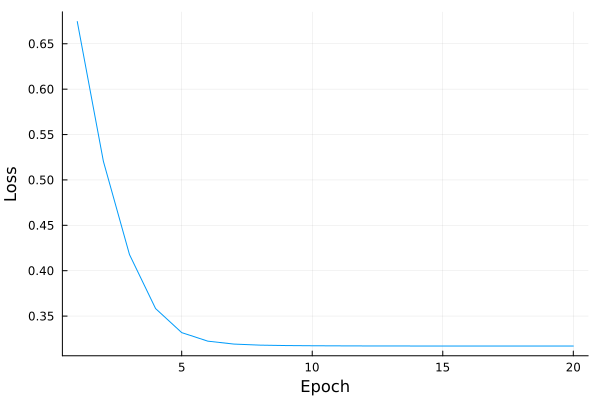

In [9]:
trained_nn = NeuralProposal(2, 2)
# create a DataLoader with batch size
batch_size = 1000
data_loader = DataLoader(data_tensors, batch_size=batch_size, shuffle=true)

# the loss function is the negative log likelihood
loss_fn = nn.BCELoss()

# the optimizer is the algorithm that updates the parameters
optimizer = torch.optim.Adam(trained_nn.parameters(), lr=0.001)

epochs = 20

mean_losses = []
for epoch = 1:epochs
    losses = []
    for (x, y) in data_loader
        # compute the output of the network
        y_pred = trained_nn(x)

        # compute the loss
        loss = loss_fn(y_pred, y)
        # add loss
        push!(losses, loss.item())

        # zero the gradients before running the backward pass.
        optimizer.zero_grad()

        # run the backward pass
        loss.backward()

        # update the parameters
        optimizer.step()
    end

    mean_loss = sum(losses) / length(losses)
    push!(mean_losses, mean_loss)
    println(epoch, ": loss: ", mean_loss)
end

println("Done training")
# plot loss
plot(mean_losses, xlabel="Epoch", ylabel="Loss", legend=false)


Lets investigate how the model "thinks"

In [10]:
println("Trained NN proposal:")
# Iterate over the combinations of John and Mary's presence
for (john, mary) in [(0, 0), (0, 1), (1, 0), (1, 1)]
    # Use the function to get the formatted output
    output = predict_and_format(john, mary, trained_nn)
    println("P(B, A | J=$john, M=$mary) ≈ (B: $(output[1]), A: $(output[2]))")
end

println("Analytical:")
print_analytical_probabilities(chance)


Trained NN proposal:
P(B, A | J=0, M=0) ≈ (B: 0.03, A: 0.05)
P(B, A | J=0, M=1) ≈ (B: 0.23, A: 0.56)
P(B, A | J=1, M=0) ≈ (B: 0.07, A: 0.17)
P(B, A | J=1, M=1) ≈ (B: 0.34, A: 0.81)
Analytical:
P(B, A | J=0, M=0) = (B: 0.03, A: 0.05)
P(B, A | J=0, M=1) = (B: 0.22, A: 0.54)
P(B, A | J=1, M=0) = (B: 0.08, A: 0.16)
P(B, A | J=1, M=1) = (B: 0.32, A: 0.8)


It learns a proposal distribution close to the true posterior!

Lets check out the accuracy

In [11]:
trained_acc = accuracy(burglar_model, test_data, nn_resimulation_burglar, trained_nn, inference_budget, chance)

println("No proposal accuracy: ", no_proposal_acc)
println("Untrained proposal accuracy: ", untrainted_acc)
println("Trained proposal accuracy: ", trained_acc)


No proposal accuracy: 0.706
Untrained proposal accuracy: 0.725
Trained proposal accuracy: 0.714


## Part 3. Inference with a recurrent neural network

In the second part we use a LSTM instead of a fully connected neural network.

In [12]:
@pydef mutable struct LSTMProposal <: nn.Module
    function __init__(self; input_size::Int, hidden_size::Int, num_layers::Int, output_size::Int, batch_first::Bool=true)
        pybuiltin(:super)(LSTMProposal, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=batch_first)
        self.fc = nn.Linear(hidden_size, output_size)
    end

    function forward(self, x, gates)
        # Assuming x is of shape (batch, seq, feature)
        lstm_output, (h_n, c_n) = self.lstm(x, gates)
        x = self.fc(lstm_output)
        x = F.sigmoid(x)
        return x, (h_n, c_n)
    end

    function hidden_size(self)
        return self.lstm.hidden_size
    end
end


# inputs: observe = [john, mary], address (one hot), x_t-1
# outputs: mean, std
# LSTM
# input size: 2 (y: john, mary) + 2 (address: burglar or alarm) + 1 (x_t-1) = 5
input_size = 5
hidden_size = 10
num_layers = 1
output_size = 1
untrained_lstm = LSTMProposal(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size)


PyObject LSTMProposal(
  (lstm): LSTM(5, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

In [13]:
@gen function lstm_proposal(trace, lstm)
    input0 = torch.tensor([trace[:john], trace[:mary], 1, 0, 0], dtype=torch.float32).view(1, 1, -1)
    gates = torch.zeros(num_layers, 1, lstm.hidden_size()), torch.zeros(num_layers, 1, lstm.hidden_size())
    nn0, gates = lstm(input0, gates)
    burglar ~ bernoulli(nn0.item())

    input1 = torch.tensor([trace[:john], trace[:mary], 0, 1, burglar], dtype=torch.float32).view(1, 1, -1)
    nn1, gates = lstm(input1, gates)
    alarm ~ bernoulli(nn1.item())
end;


function lstm_resimulation_burglar(john, mary, budget=1000, chance=0.5, network=lstm)
    observations = Gen.choicemap()
    observations[:john] = john
    observations[:mary] = mary
    (tr,) = Gen.generate(burglar_model, (chance,), observations)
    for iter = 1:budget
        (tr,) = mh(tr, lstm_proposal, (network,))
    end
    tr
end;

untrained_lstm_acc = accuracy(burglar_model, test_data, lstm_resimulation_burglar, untrained_lstm, inference_budget, chance)


0.713

In [14]:
# Assuming generate_data is a function that generates the necessary data
train_data_size = 100000
train_data = generate_data(burglar_model, train_data_size, chance)

# Convert data to tensors and zip them
data_tensors = []
for trace in train_data
    # Extract and convert features to tensors
    john = torch.tensor([trace[:john]], dtype=torch.float32)
    mary = torch.tensor([trace[:mary]], dtype=torch.float32)
    burglar = torch.tensor([trace[:burglar]], dtype=torch.float32)
    alarm = torch.tensor([trace[:alarm]], dtype=torch.float32)

    # Combine john and mary observations
    observations = torch.cat((john, mary), dim=-1)

    # Combine the one hot encoded previous address and x_t-1 for burglar
    burglar_address = torch.tensor([1.0, 0.0, 0.0], dtype=torch.float32)
    input_burglar = torch.cat((observations, burglar_address), dim=-1)

    # Combine the one hot encoded previous address and x_t-1 for alarm
    alarm_address = torch.tensor([0.0, 1.0, burglar], dtype=torch.float32)
    input_alarm = torch.cat((observations, alarm_address), dim=-1)

    x = torch.stack((input_burglar, input_alarm))
    y = torch.cat((burglar, alarm))

    # The data tensor for each trace will be a tuple of inputs and the target
    push!(data_tensors, (x, y))
end
batch_size = 1000
data_loader = DataLoader(data_tensors, batch_size=batch_size, shuffle=true)


PyObject <torch.utils.data.dataloader.DataLoader object at 0x2c6ddafe0>

1: loss: 0.6700710976123809


2: loss: 0.5211956867575646


3: loss: 0.4073908764123917


4: loss: 0.331811888217926


5: loss: 0.2992652222514153


6: loss: 0.2896659329533577


7: loss: 0.2863475269079208


8: loss: 0.2845568871498108


9: loss: 0.28347473114728927


10: loss: 0.2828389820456505


11: loss: 0.2824099762737751


12: loss: 0.2821543021500111


13: loss: 0.28198104470968244


14: loss: 0.2817871189117432


15: loss: 0.28162340983748435


16: loss: 0.2815384939312935


17: loss: 0.28138394474983214


18: loss: 0.28128721937537193


19: loss: 0.2811706234514713


20: loss: 0.28111345529556275
Done training


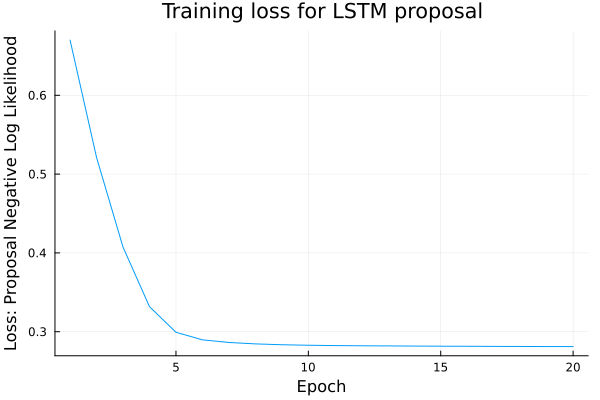

In [15]:
trained_lstm = LSTMProposal(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size)
# the optimizer is the algorithm that updates the parameters
optimizer = torch.optim.Adam(trained_lstm.parameters(), lr=0.001)

# we will train for 100 epochs
epochs = 20
# loss function is negative log likelihood
# this is BCE (Binary Cross Entropy) for the bernoulli distribution
loss_fn = nn.BCELoss()

mean_losses = []
for epoch = 1:epochs
    losses = []
    for (x, y) in data_loader
        # x is batch x seq x feature
        # y is batch x feature
        # compute the output of the network
        gates = torch.zeros(num_layers, batch_size, hidden_size), torch.zeros(num_layers, batch_size, hidden_size)
        y_pred, gates = trained_lstm(x, gates)

        loss = loss_fn(y_pred.flatten(1), y)

        # add loss
        push!(losses, loss.item())

        # zero the gradients before running the backward pass.
        optimizer.zero_grad()

        # run the backward pass
        loss.backward()

        # update the parameters
        optimizer.step()

    end

    mean_loss = sum(losses) / length(losses)
    push!(mean_losses, mean_loss)
    println(epoch, ": loss: ", mean_loss)
end

println("Done training")
# plot loss and likelihood

plot(mean_losses, xlabel="Epoch", ylabel="Loss: Proposal Negative Log Likelihood", legend=false)
title!("Training loss for LSTM proposal")


In [16]:
trained_lstm_acc = accuracy(burglar_model, test_data, lstm_resimulation_burglar, trained_lstm, inference_budget, chance)
println("Untrained LSTM proposal accuracy: ", untrained_lstm_acc)
println("Trained LSTM proposal accuracy: ", trained_lstm_acc)


Untrained LSTM proposal accuracy: 0.713
Trained LSTM proposal accuracy: 0.731


In [17]:
# test all the cases in the LSTM

# input is tuple (john, mary) (4 cases)
# output burglar probability

for (john, mary) in [(0, 0), (0, 1), (1, 0), (1, 1)]
    # Use the function to get the formatted output
    input = torch.tensor([john, mary, 1, 0, 0], dtype=torch.float32)
    gates = torch.zeros(num_layers, 1, hidden_size), torch.zeros(num_layers, 1, hidden_size)
    output, gates = trained_lstm(input.view(1, 1, -1), gates)
    println("P(B | J=$john, M=$mary) ≈ $(round(output.item(), digits=2))")
    analytical_burglar = calc_P_burglar_given_JM(chance, john, mary)
    println("Analytical: $(round(analytical_burglar, digits=2))")
    for burglar in [0, 1]
        input = torch.tensor([john, mary, 0, 1, burglar], dtype=torch.float32)
        output, _ = trained_lstm(input.view(1, 1, -1), gates)
        println("P(A | B=$burglar, J=$john, M=$mary) ≈ $(round(output.item(), digits=2))")
    end
    println()
end


P(B | J=0, M=0) ≈ 0.04
Analytical: 0.03
P(A | B=0, J=0, M=0) ≈ 0.03
P(A | B=1, J=0, M=0) ≈ 0.65

P(B | J=0, M=1) ≈ 0.21
Analytical: 0.22
P(A | B=0, J=0, M=1) ≈ 0.42
P(A | B=1, J=0, M=1) ≈ 0.96

P(B | J=1, M=0) ≈ 0.06
Analytical: 0.08
P(A | B=0, J=1, M=0) ≈ 0.11
P(A | B=1, J=1, M=0) ≈ 0.87

P(B | J=1, M=1) ≈ 0.34
Analytical: 0.32
P(A | B=0, J=1, M=1) ≈ 0.72
P(A | B=1, J=1, M=1) ≈ 0.97



## Part 4. Experiments

### Compare Inference Methods for different budgets

In [18]:

mh_budgets = [1, 3, 5, 10]
test_budget = 10000
test_data = generate_data(burglar_model, test_budget, chance)


inferene_procedures = [
    ("Block", block_resimulation_burglar, nothing),
    ("Untrained NN", nn_resimulation_burglar, untrained_nn),
    ("Trained NN", nn_resimulation_burglar, trained_nn),
    ("Untrained LSTM", lstm_resimulation_burglar, untrained_lstm),
    ("Trained LSTM", lstm_resimulation_burglar, trained_lstm)]

results = []
for (name, inference, network) in inferene_procedures
    procedure_results = []
    for budget in mh_budgets
        println("Running experiment for $name with budget $budget")
        acc = accuracy(burglar_model, test_data, inference, network, budget, chance)
        push!(procedure_results, acc)
    end
    push!(results, procedure_results)
end


Running experiment for Block with budget 1
Running experiment for Block with budget 3


Running experiment for Block with budget 5


Running experiment for Block with budget 10


Running experiment for Untrained NN with budget 1


Running experiment for Untrained NN with budget 3


Running experiment for Untrained NN with budget 5


Running experiment for Untrained NN with budget 10


Running experiment for Trained NN with budget 1


Running experiment for Trained NN with budget 3


Running experiment for Trained NN with budget 5


Running experiment for Trained NN with budget 10


Running experiment for Untrained LSTM with budget 1


Running experiment for Untrained LSTM with budget 3


Running experiment for Untrained LSTM with budget 5


Running experiment for Untrained LSTM with budget 10


Running experiment for Trained LSTM with budget 1


Running experiment for Trained LSTM with budget 3


Running experiment for Trained LSTM with budget 5


Running experiment for Trained LSTM with budget 10


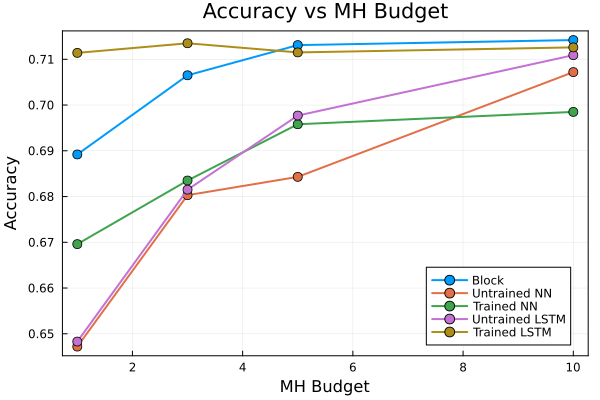

In [19]:

# plot the results
plot(mh_budgets, results, xlabel="MH Budget", ylabel="Accuracy", label=["Block" "Untrained NN" "Trained NN" "Untrained LSTM" "Trained LSTM"],
legend=:bottomright, title="Accuracy vs MH Budget", markershape=:circle, markersize=5, markercolor=:auto, linewidth=2, framestyle=:box)

### Meta Learning Experiments

Lets investigate how the hidden dimension of the LSTM affects the accuracy

Training LSTM with hidden dimension 1


Training LSTM with hidden dimension 2


Training LSTM with hidden dimension 3


Training LSTM with hidden dimension 5


Training LSTM with hidden dimension 10


Training LSTM with hidden dimension 20


Training LSTM with hidden dimension 50


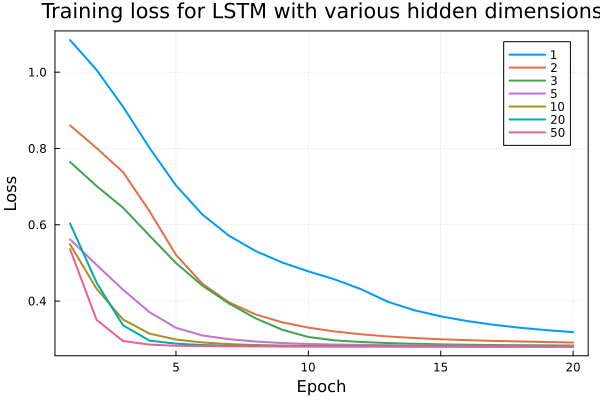

In [20]:
function train_lstm(lstm, data_loader, epochs, loss_fn, learning_rate)
    optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
    mean_losses = []
    hidden_size = lstm.hidden_size()

    for epoch = 1:epochs
        losses = []
        for (x, y) in data_loader
            gates = torch.zeros(num_layers, batch_size, hidden_size), torch.zeros(num_layers, batch_size, hidden_size)
            y_pred, gates = lstm(x, gates)
            loss = loss_fn(y_pred.flatten(1), y)
            push!(losses, loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        end

        mean_loss = sum(losses) / length(losses)
        push!(mean_losses, mean_loss)
    end

    return mean_losses
end


hiden_sizes = [1, 2, 3, 5, 10, 20, 50]
# train the lstms and plot the loss functions in the same plot
loss_fn = nn.BCELoss()
epochs = 20
learning_rate = 0.001
mean_losses = []
lstms = []
for hidden_size in hiden_sizes
    lstm = LSTMProposal(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size)
    println("Training LSTM with hidden dimension $(hidden_size)")
    losses = train_lstm(lstm, data_loader, epochs, loss_fn, learning_rate)
    push!(mean_losses, losses)
    push!(lstms, lstm)
end
plot(mean_losses, xlabel="Epoch", ylabel="Loss", title="Training loss for LSTM with various hidden dimensions", label=["1" "2" "3" "5" "10" "20" "50"], linewidth=2, framestyle=:box)


Running experiment for 1 with budget 1


Running experiment for 2 with budget 1


Running experiment for 3 with budget 1


Running experiment for 5 with budget 1


Running experiment for 10 with budget 1


Running experiment for 20 with budget 1


Running experiment for 50 with budget 1


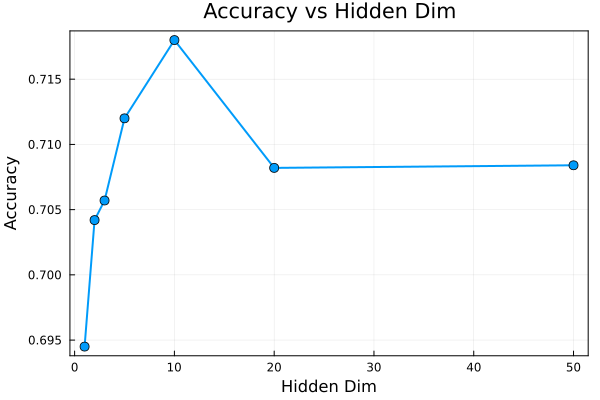

In [21]:
mh_budget = 1
inferene_procedures = [(lstm.hidden_size(), lstm_resimulation_burglar, lstm) for lstm in lstms]
results = []
for (name, inference, network) in inferene_procedures
    println("Running experiment for $name with budget $mh_budget")
    acc = accuracy(burglar_model, test_data, inference, network, mh_budget, chance)
    push!(results, acc)
end
plot(hiden_sizes, results, xlabel="Hidden Dim", ylabel="Accuracy", legend=false, markershape=:circle, markersize=5, markercolor=:auto, linewidth=2, framestyle=:box)
title!("Accuracy vs Hidden Dim")